# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off-Speed RHP](#off-Speed-RHP)
    - [Off-Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705396, 68)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,delta_run_exp,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,woba_value,woba_denom,xba,xwoba,babip_value,iso_value,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,arm_angle,slot,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,-0.073,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,2.0,0.0,1.0,0.174,0.158,0.0,0.0,61,4,9,0,5,0,5,0,0,0,0,2,36.0,1,1,0,1,1,0,0,0,0.11,-0.11,0.00,-0.11,-0.271,0.0,1.209,-0.328,0.0,0.222,-0.152,-0.262
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,-0.027,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,45.8,2,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.300,-0.053,-0.053
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,-0.020,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,38.4,1,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.356,-0.038,-0.038
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,0.016,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,38.4,1,0,1,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.314,0.028,0.028
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,-0.189,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,2.0,0.0,1.0,0.100,0.090,0.0,0.0,60,2,9,0,5,0,5,0,0,0,0,1,36.0,1,1,0,1,0,0,0,0,0.29,-0.18,0.11,-0.18,-0.271,0.0,1.209,-0.328,0.0,0.356,-0.038,-0.218


### Features

**Independent Variables:** Velocity, Spin Rate, HB, VB, Release Side, Release Height, Arm Angle, Release Extension

**Dependent Variable:** Run Value

In [7]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                 'release_pos_x', 'release_pos_z', 'rv']]

In [8]:
fastball = features[features['pitch_type'].isin(['FF', 'FC', 'SI'])]
breaking_ball = features[features['pitch_type'].isin(['SL', 'CU', 'KC'])]
offspeed = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fastball = fastball.loc[fastball['p_throws'] == 'R']
lhp_fastball = fastball.loc[fastball['p_throws'] == 'L']
rhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
lhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
rhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'R']
lhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'L']
ff_r = rhp.loc[rhp['pitch_type'] == 'FF']
ff_l = lhp.loc[lhp['pitch_type'] == 'FF']
fc_r = rhp.loc[rhp['pitch_type'] == 'FC']
fc_l = lhp.loc[lhp['pitch_type'] == 'FC']
si_r = rhp.loc[rhp['pitch_type'] == 'SI']
si_l = lhp.loc[lhp['pitch_type'] == 'SI']
sl_r = rhp.loc[rhp['pitch_type'] == 'SL']
sl_l = lhp.loc[lhp['pitch_type'] == 'SL']
cu_r = rhp.loc[rhp['pitch_type'] == 'CU']
cu_l = lhp.loc[lhp['pitch_type'] == 'CU']
ch_r = rhp.loc[rhp['pitch_type'] == 'CH']
ch_l = lhp.loc[lhp['pitch_type'] == 'CH']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Cutter, Sinker

In [9]:
print('Baseline RHP Fastball RunValue Accuracy Score:', round(rhp_fastball.rv.mean(), 2))

Baseline RHP Fastball RunValue Accuracy Score: -0.02


In [10]:
features_fastball_r = rhp_fastball.select_dtypes([np.number])
X = features_fastball_r.drop(columns = ['rv'])
y = features_fastball_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fastball_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fastball_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.04
Test RMSE: 0.282
Test MAE: 0.159 

R2 Score: 0.632
RMSE: 0.168
MAE: 0.085


### RV

In [ ]:
fastball_rhp = rhp_fastball.copy()
fastball_rhp['xRV'] = pred
fastball_rhp['xRV'] = round(fastball_rhp['xRV'], 3)
rhp_fastball['FF_count'] = [1 if x == 'FF' else 0 for x in rhp_fastball['pitch_type']]
rhp_fastball['SI_count'] = [1 if x == 'SI' else 0 for x in rhp_fastball['pitch_type']]
rhp_fastball['FC_count'] = [1 if x == 'FC' else 0 for x in rhp_fastball['pitch_type']]

feldman_ff = 
pred_feldman_ff = rf.predict(feldman_ff)
columns = ['player_name', 'pitch_type', 'velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 'release_pos_z']
feldman_rv = pd.DataFrame(data = feldman_ff, columns = columns)
feldman_ff['xRV'] = pred_feldman_ff
feldman_ff.head()

In [ ]:
steinfort_ff = 
pred_steinfort_ff = rf.predict(steinfort_ff)
steinfort_rv = pd.DataFrame(data = steinfort_ff, columns = columns)
steinfort_ff['xRV'] = pred_steinfort_ff
steinfort_ff.head()

### RHP Fastball RV Table

Velocity, Spin Rate, HB, VB, Release Side, Release Height, Arm Angle, Release Extension

### RHP Fastball xRV by HB & VB

In [ ]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(rhp_fastball['pfx_x'], rhp_fastball['pfx_z'], C = rhp_fastball['xRV'], 
                cmap = 'coolwarm', mincnt = 20, gridsize = 10)
sns.scatterplot(data = feldman_ff, x = 'HB', y = 'VB', cmap = 'coolwarm_r')
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'FF Dead Zone')
cb = plt.colorbar(ax, ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('RHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

RHP Fastball Avg xRunValue: -0.02


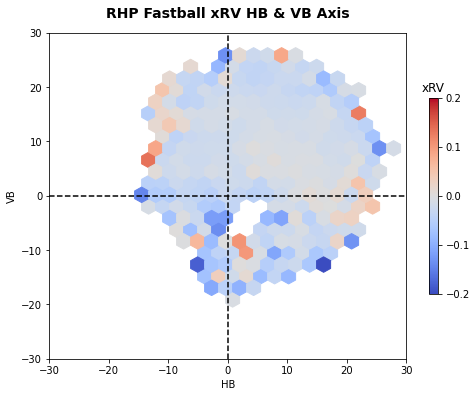

In [9]:
plt.figure(figsize = (8, 6))
plt.hexbin(rhp_fastball['pfx_x'], rhp_fastball['pfx_z'], C = rhp_fastball['xRV'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
cb = plt.colorbar(ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg xRunValue:', round(rhp_fastball.xRV.mean(), 2))

## Breaking Ball RHP

#### Slider, Curveball, Knuckle Curve

In [21]:
print('Baseline RHP Breaking Ball RunValue Accuracy Score:', round(rhp_breaking_ball.rv.mean(), 2))

Baseline RHP Breaking Ball RunValue Accuracy Score: -0.04


In [22]:
features_bb_r = rhp_breaking_ball.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_bb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.035
Test RMSE: 0.275
MAE: 0.158 

R2 Score: 0.634
Test RMSE: 0.164
MAE: 0.084


### RHP Breaking Ball RV

In [ ]:
rhp_bb = rhp_breaking_ball.copy()
rhp_bb['xRV'] = pred
rhp_bb['xRV'] = round(rhp_bb['xRV'], 3)
rhp_bb['SL_count'] = [1 if x == 'SL' else 0 for x in rhp_fastball['pitch_type']]
rhp_bb['CU_count'] = [1 if x == 'CU' else 0 for x in rhp_fastball['pitch_type']]
rhp_bb['KC_count'] = [1 if x == 'KC' else 0 for x in rhp_fastball['pitch_type']]

feldman_bb = 
pred_feldman_bb = rf.predict(feldman_bb)
#columns = ['player_name', 'pitch_type', 'velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 'release_pos_z']
feldman_rv_bb = pd.DataFrame(data = feldman_bb, columns = columns)
feldman_bb['xRV'] = pred_feldman_bb
feldman_bb.head()

In [ ]:
steinfort_bb = 
pred_steinfort_bb = rf.predict(steinfort_bb)
steinfort_rv_bb = pd.DataFrame(data = steinfort_bb, columns = columns)
steinfort_bb['xRV'] = pred_steinfort_bb
steinfort_bb.head()

### RHP Breaking Ball xRV by HB & VB

RHP Breaking Ball Avg xRunValue: -0.04


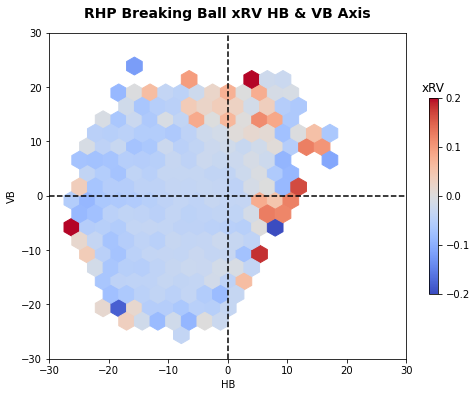

In [25]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(rhp_breaking_ball['pfx_x'], rhp_breaking_ball['pfx_z'], C = rhp_breaking_ball['xRV'],
                cmap='coolwarm', mincnt = 1, gridsize = 20)
sns.scatterplot(data = feldman_ff, x = 'HB', y = 'VB', cmap = 'coolwarm_r')
cb = plt.colorbar(ax, ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed RHP

#### Changeup, Splitter

In [37]:
print('Baseline RHP Off-Speed RunValue Accuracy Score:', round(rhp_offspeed.rv.mean(), 2))

Baseline RHP Off-Speed RunValue Accuracy Score: -0.04


In [38]:
features_os_r = rhp_offspeed.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_os_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.037
Test RMSE: 0.282
Test MAE: 0.166 

R2 Score: 0.632
RMSE: 0.168
MAE: 0.089


### RHP OS RV

In [ ]:
rhp_os = rhp_os.copy()
rhp_os['xRV'] = pred
rhp_os['xRV'] = round(rhp_os['xRV'], 3)
rhp_os['SL_count'] = [1 if x == 'CH' else 0 for x in rhp_os['pitch_type']]
rhp_os['CU_count'] = [1 if x == 'FS' else 0 for x in rhp_os['pitch_type']]

feldman_os = 
pred_feldman_os = rf.predict(feldman_os)
#columns = ['player_name', 'pitch_type', 'velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 'release_pos_z']
feldman_rv_os = pd.DataFrame(data = feldman_os, columns = columns)
feldman_os['xRV'] = pred_feldman_os
feldman_os.head()

In [ ]:
steinfort_os = 
pred_steinfort_os = rf.predict(steinfort_os)
steinfort_rv_os = pd.DataFrame(data = steinfort_os, columns = columns)
steinfort_os['xRV'] = pred_steinfort_os
steinfort_os.head()

### RHP Off-Speed xRV by HB & VB

RHP Off-Speed Avg xRunValue: -0.03


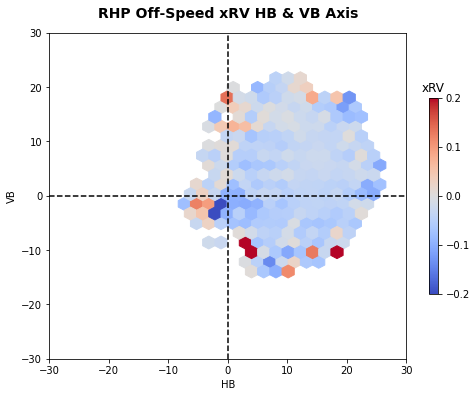

In [41]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
sns.scatterplot(data = feldman_os, x = 'HB', y = 'VB', hue = 'xRV', cmap = 'coolwarm_r')
cb = plt.colorbar(ax, ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Feldman Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg xRunValue:', round(rhp_offspeed.xRV.mean(), 2))

In [ ]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
sns.scatterplot(data = steinfort_os, x = 'HB', y = 'VB', hue = 'xRV', cmap = 'coolwarm_r')
cb = plt.colorbar(ax, ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('Steinfort Off-Speed Avg xRunValue:', round(rhp_offspeed.xRV.mean(), 2))